# Quantum. Project 4. Quantum Oracle Preparation for Grover’s Algorithm

Author:
- ***Nikita Makarevich (Student ID: 153989)***

$$
\renewcommand{\bra}[1]{\langle #1|}
\renewcommand{\ket}[1]{|#1\rangle}
\renewcommand{\braket}[2]{\langle #1|#2\rangle}
$$

In [69]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.quantum_info import Operator
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from dataclasses import dataclass

# selection of quantum simulator (or processor)
backend = Aer.get_backend("qasm_simulator")

In [10]:
def plot_circuit(circuit: QuantumCircuit, *, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
    circuit.draw("mpl", ax=ax)
    return ax

In [36]:
@dataclass
class Setup:
    n: int
    qx: QuantumRegister
    cx: ClassicalRegister | None
    circuit: QuantumCircuit

    @classmethod
    def create_quantum_only(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        circ = QuantumCircuit(qx, **circuit_kwargs)
        return cls(n, qx, None, circ)

    @classmethod
    def create(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        cx = ClassicalRegister(n, "c")
        circ = QuantumCircuit(qx, cx, **circuit_kwargs)
        return cls(n, qx, cx, circ)

## 1. Oracle Matrices of $U_f$ operation

In [37]:
def get_xor_oracle_matrix(a_bits: str) -> np.ndarray:
    """Generate the oracle matrix for the XOR function."""

    def _func(x_bits: str) -> int:
        return int(x_bits == a_bits)

    if len(a_bits) != 2:
        raise ValueError("a_bits must be a 2-bit string.")

    matrix = np.zeros((8, 8), dtype=int)
    for i in range(8):
        i_bits = f"{i:03b}"
        y_bit = i_bits[0]
        x_bits = i_bits[-2:]
        output_bits = str(_func(x_bits) ^ int(y_bit)) + x_bits
        j = int(output_bits, 2)
        matrix[j, i] = 1

    return matrix


def get_phase_oracle_matrix(a_bits: str) -> np.ndarray:
    """Generate the oracle matrix for the phase oracle."""

    def _func(x_bits: str) -> int:
        return int(x_bits == a_bits)

    if len(a_bits) != 3:
        raise ValueError("a_bits must be a 3-bit string.")

    matrix = np.eye(8, dtype=int)
    for i in range(8):
        i_bits = f"{i:03b}"
        x_bits = i_bits
        matrix[i, i] = (-1) ** _func(x_bits)

    return matrix

In [107]:
XOR_A_BITS = "00"
PHASE_A_BITS = "011"

In [108]:
xor_oracle_matrix = get_xor_oracle_matrix(XOR_A_BITS)
print("XOR Oracle Matrix:")
print(xor_oracle_matrix)

XOR Oracle Matrix:
[[0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


In [109]:
phase_oracle_matrix = get_phase_oracle_matrix(PHASE_A_BITS)
print("Phase Oracle Matrix:")
print(phase_oracle_matrix)

Phase Oracle Matrix:
[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1]]


## 2. Quantum Gate for $U_f$ matrices

In [110]:
def connect_xor_oracle(setup: Setup, a_bits: str) -> None:
    """Connect the XOR oracle to the circuit."""
    flipped_idxs: list[int] = []
    for i, a_bit in enumerate(a_bits[::-1]):
        if a_bit == "0":
            setup.circuit.x(setup.qx[i])
            flipped_idxs.append(i)
    setup.circuit.mcx(setup.qx[:-1], setup.qx[-1])
    for i in flipped_idxs:
        setup.circuit.x(setup.qx[i])


def connect_phase_oracle(setup: Setup, a_bits: str) -> None:
    """Connect the XOR oracle to the circuit."""
    flipped_idxs: list[int] = []
    for i, a_bit in enumerate(a_bits[::-1]):
        if a_bit == "0":
            setup.circuit.x(setup.qx[i])
            flipped_idxs.append(i)
    setup.circuit.h(setup.qx[-1])
    setup.circuit.mcx(setup.qx[:-1], setup.qx[-1])
    setup.circuit.h(setup.qx[-1])
    for i in flipped_idxs:
        setup.circuit.x(setup.qx[i])

### XOR Oracle Gate for $00$

Circuit for XOR Oracle:


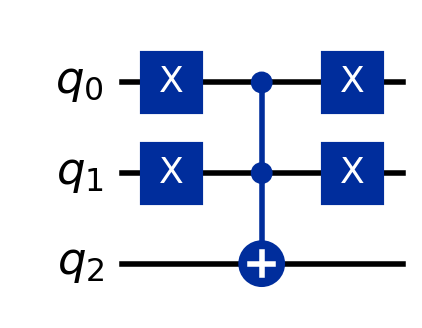

Checking that matrix representation is the same
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [111]:
setup = Setup.create_quantum_only(n=3)
connect_xor_oracle(setup, XOR_A_BITS)

plot_circuit(setup.circuit)
print("Circuit for XOR Oracle:")
plt.show()
print("Checking that matrix representation is the same")
print(Operator(setup.circuit).to_matrix())

### Phase Oracle Gate for $011$

Circuit for Phase Oracle:


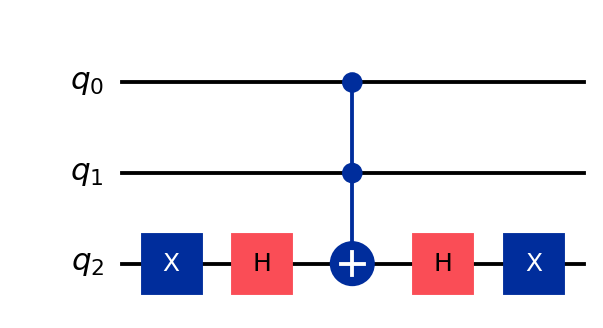

Checking that matrix representation is the same
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [112]:
setup = Setup.create_quantum_only(n=3)
connect_phase_oracle(setup, PHASE_A_BITS)

plot_circuit(setup.circuit)
print("Circuit for Phase Oracle:")
plt.show()
print("Checking that matrix representation is the same")
print(Operator(setup.circuit).to_matrix())

## 3. Calculating $\ket{0}_3 {}_3\bra{0}$

$$
\ket{0}_3 {}_3\bra{0}
=
\begin{bmatrix}
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 
\end{bmatrix}

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}

=

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
$$


$$
\ket{1}_3 {}_3\bra{1}
=
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
1 
\end{bmatrix}

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}

=

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
$$

*We will need the $\ket{1}_3 {}_3\bra{1}$ for later*

## 4. Calculating $2\ket{0}_3 {}_3\bra{0} - \hat{I}$

We substitute $\ket{0}_3 {}_3\bra{0}$ from previous calculation...

$$
2\ket{0}_3 {}_3\bra{0} - \hat{I}
=
2
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
-
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}

=

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 
\end{bmatrix}
$$

$$
\renewcommand{\xn}[0]{\hat{X}^{\oplus 3}}
\renewcommand{\xnmatrix}[0]{
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
}
$$

## 5. Calculating $\xn (2\ket{0}_3 {}_3\bra{0} - \hat{I}) \xn$

We substitute $2\ket{0}_3 {}_3\bra{0} - \hat{I}$ from previous calculation...

$$
\xn
=
\xnmatrix
$$

$$
\xn (2\ket{0}_3 {}_3\bra{0} - \hat{I}) \xn
=
\xnmatrix
(
    \begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 
    \end{bmatrix}
    \xnmatrix
)
=
$$

$$
=
\xnmatrix
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
=
\begin{bmatrix}
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
$$


$$
2\ket{1}_3 {}_3\bra{1} - \hat{I}
=
2
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
-
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
=
\begin{bmatrix}
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
$$

We see that indeed $\xn (2\ket{0}_3 {}_3\bra{0} - \hat{I}) \xn = 2\ket{1}_3 {}_3\bra{1} - \hat{I}$

## 6. Calculating Grover's Diffusion Operator $W$

### Calculating Hadamard Matrices

$$
\renewcommand{\hn}[0]{\hat{H}^{\otimes 3}}
\renewcommand{\hnmatrix}[0]{
    \begin{bmatrix}
    1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
    1 & -1 & 1 & -1 & 1 & -1 & 1 & -1 \\
    1 & 1 & -1 & -1 & 1 & 1 & -1 & -1 \\
    1 & -1 & -1 & 1 & 1 & -1 & -1 & 1 \\
    1 & 1 & 1 & 1 & -1 & -1 & -1 & -1 \\
    1 & -1 & 1 & -1 & -1 & 1 & -1 & 1 \\
    1 & 1 & -1 & -1 & -1 & -1 & 1 & 1 \\
    1 & -1 & -1 & 1 & -1 & 1 & 1 & -1 
    \end{bmatrix}
}
$$

First we need to calculate $\hn$...

$$
H
=
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1 \\
\end{bmatrix}
$$

$$
H \otimes H 
=
\frac{1}{\sqrt{4}}
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1 
\end{bmatrix}
$$

$$
\hn
=
H \otimes (H \otimes H)
=
\frac{1}{\sqrt{8}}
\hnmatrix
$$

### Calculating $W$

$$
W = \hn(2\ket{0}_3 {}_3\bra{0} - \hat{I})\hn =
$$
$$
=
\frac{1}{\sqrt{64}}
\hnmatrix
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 
\end{bmatrix}
\hnmatrix
=
$$

$$
=
\frac{1}{8}
\hnmatrix
\begin{bmatrix}
 1 &  1 &  1 &  1 &  1 &  1 &  1 &  1 \\
-1 &  1 & -1 &  1 & -1 &  1 & -1 &  1 \\
-1 & -1 &  1 &  1 & -1 & -1 &  1 &  1 \\
-1 &  1 &  1 & -1 & -1 &  1 &  1 & -1 \\
-1 & -1 & -1 & -1 &  1 &  1 &  1 &  1 \\
-1 &  1 & -1 &  1 &  1 & -1 &  1 & -1 \\
-1 & -1 &  1 &  1 &  1 &  1 & -1 & -1 \\
-1 &  1 &  1 & -1 &  1 & -1 & -1 &  1 
\end{bmatrix}
=
$$

$$
=
\frac{1}{8}
\begin{bmatrix}
-6 &  2 &  2 &  2 &  2 &  2 &  2 &  2 \\
 2 & -6 &  2 &  2 &  2 &  2 &  2 &  2 \\
 2 &  2 & -6 &  2 &  2 &  2 &  2 &  2 \\
 2 &  2 &  2 & -6 &  2 &  2 &  2 &  2 \\
 2 &  2 &  2 &  2 & -6 &  2 &  2 &  2 \\
 2 &  2 &  2 &  2 &  2 & -6 &  2 &  2 \\
 2 &  2 &  2 &  2 &  2 &  2 & -6 &  2 \\
 2 &  2 &  2 &  2 &  2 &  2 &  2 & -6 
\end{bmatrix}
=
\frac{1}{4}
\begin{bmatrix}
-3 &  1 &  1 &  1 &  1 &  1 &  1 &  1 \\
 1 & -3 &  1 &  1 &  1 &  1 &  1 &  1 \\
 1 &  1 & -3 &  1 &  1 &  1 &  1 &  1 \\
 1 &  1 &  1 & -3 &  1 &  1 &  1 &  1 \\
 1 &  1 &  1 &  1 & -3 &  1 &  1 &  1 \\
 1 &  1 &  1 &  1 &  1 & -3 &  1 &  1 \\
 1 &  1 &  1 &  1 &  1 &  1 & -3 &  1 \\
 1 &  1 &  1 &  1 &  1 &  1 &  1 & -3 
\end{bmatrix}

$$

## 7. Quantum Gates for $U_f$ and $W$

### $U_f$ Gate

In [85]:
def get_oracle_as_gate(
    oracle_matrix: np.ndarray, *, n: int, name: str | None = None
) -> Gate:
    """Convert an oracle matrix to a Qiskit Operator gate."""
    oracle_op = Operator(oracle_matrix)

    if not oracle_op.is_unitary():
        raise ValueError("The provided oracle matrix is not unitary.")

    setup = Setup.create_quantum_only(n=n, name=name)
    setup.circuit.append(oracle_op, setup.qx)

    return setup.circuit.to_gate()

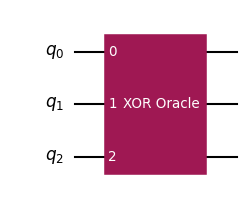

In [86]:
xor_oracle_gate = get_oracle_as_gate(xor_oracle_matrix, n=3, name="XOR Oracle")

setup = Setup.create_quantum_only(n=3)
setup.circuit.append(xor_oracle_gate, setup.qx)

fig, ax = plt.subplots(figsize=(3, 3))
_ = plot_circuit(setup.circuit, ax=ax)

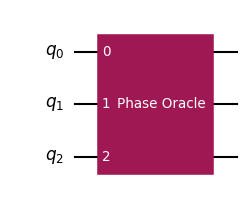

In [87]:
phase_oracle_gate = get_oracle_as_gate(phase_oracle_matrix, n=3, name="Phase Oracle")

setup = Setup.create_quantum_only(n=3)
setup.circuit.append(phase_oracle_gate, setup.qx)

fig, ax = plt.subplots(figsize=(3, 3))
_ = plot_circuit(setup.circuit, ax=ax)

### Grovers $W$ Gate

In [ ]:
def connect_grovers_w(setup: Setup) -> None:
    for i in range(setup.n):
        setup.circuit.h(setup.qx[i])
        setup.circuit.x(setup.qx[i])
    setup.circuit.h(setup.qx[setup.n - 1])
    setup.circuit.mcx(setup.qx[0 : setup.n - 1], setup.qx[setup.n - 1])
    setup.circuit.h(setup.qx[setup.n - 1])

    # setup.circuit.barrier(*setup.qx)

    for i in range(setup.n):
        setup.circuit.x(setup.qx[i])
        setup.circuit.h(setup.qx[i])

    # setup.circuit.barrier(*setup.qx)


def create_grovers_w_gate(n: int) -> Gate:
    setup = Setup.create_quantum_only(n=n, name="Grover's W")
    connect_grovers_w(setup)
    return setup.circuit.to_gate()

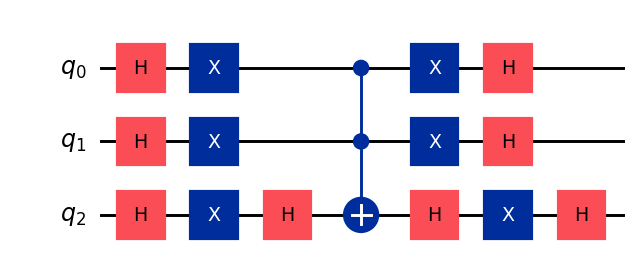

In [81]:
setup = Setup.create_quantum_only(n=3)
connect_grovers_w(setup)

_ = plot_circuit(setup.circuit)

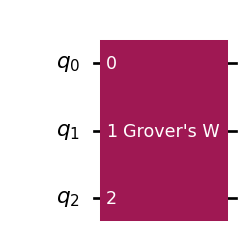

In [113]:
grovers_w_gate = create_grovers_w_gate(n=3)

setup = Setup.create_quantum_only(n=3)
setup.circuit.append(grovers_w_gate, setup.qx)

fig, ax = plt.subplots(figsize=(3, 4))
_ = plot_circuit(setup.circuit, ax=ax)